In [94]:
import skimage
from skimage import io
from skimage import feature
from skimage import measure
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
datafolder = '/Users/{user}/Dropbox/CDIPS/'.format(user=os.environ['USER'])
trainfolder = os.path.join(datafolder,'train')
testfolder = os.path.join(datafolder,'test')

In [32]:
trainimages = glob.glob(os.path.join(trainfolder, '*.tif'))

In [33]:
training = pd.read_csv(os.path.join(datafolder,'train_masks.csv'))
training.head(10)

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN
5,1,6,NaN
6,1,7,172767 15 173175 29 173591 34 173993 7 174004 ...
7,1,8,NaN
8,1,9,NaN
9,1,10,NaN


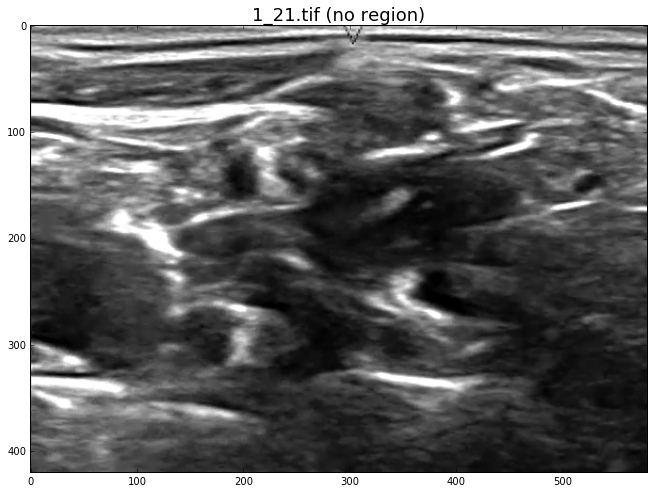

In [199]:
def load_image(idx, training):
    nameformat = '{subject}_{img}.tif'
    maskformat = '{subject}_{img}_mask.tif'
    #skimage.io.imread(os.path.join(imagefolder,''))
    imagefile = nameformat.format(subject=training['subject'][idx],
                              img=training['img'][idx])
    maskfile = maskformat.format(subject=training['subject'][idx],
                              img=training['img'][idx])
    image = io.imread(os.path.join(trainfolder, imagefile))
    mask = io.imread(os.path.join(trainfolder, maskfile))   
    return (image, mask, imagefile)

def plot_image(image, mask, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    ax.imshow(image, cmap=plt.cm.gray)
    #maskoutline = np.ma.masked_equal(feature.canny(mask),0)
    #cmap = colors.ListedColormap(['yellow', 'white'])
    #ax.imshow(maskoutline, cmap=cmap)
    maskcontour = measure.find_contours(mask, 254.5)
    if not maskcontour==[]:
        ax.plot(maskcontour[0][:,1], maskcontour[0][:,0], linewidth=2)
        ax.set_title(title)
    else:
        ax.set_title(title + ' (no region)', fontsize=18)
    ax.set_aspect('equal')
    ax.autoscale(tight=True)
    return ax

image, mask, title = load_image(20, training)
ax = plot_image(image, mask, title)

In [200]:
from skimage.morphology import skeletonize
skeleton = skeletonize(image/image.max())
plot_image(skeleton, mask, title, ax=ax)


## scoring

## reduced size images

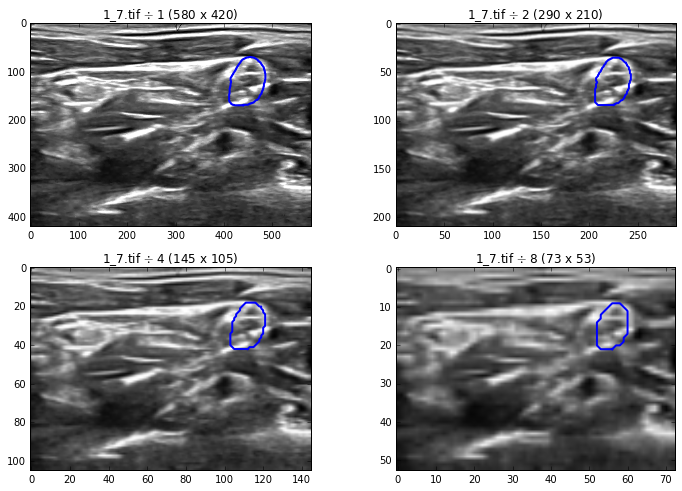

In [217]:
from skimage import transform
def reduce(image, mask, scale=4):
    reducedimage = transform.pyramid_reduce(image, downscale=scale)
    reducedmask = mask[::scale, ::scale]
    return reducedimage, reducedmask

image, mask, title = load_image(6, training)

fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()
scale=1
plot_image(image, mask, title + r' $\div$ {} ({} x {})'.format(scale, image.shape[1], image.shape[0] ), ax=ax[0])
for iax, scale in enumerate((2, 4, 8)):
    rimage, rmask = reduce(image, mask, scale=scale)
    plot_image(rimage, rmask, title + r' $\div$ {} ({} x {})'.format(scale, rimage.shape[1], rimage.shape[0] ), ax=ax[iax+1])



In [255]:
def RLE(mask):
    """Convert mask to run length encoded format
    This must be the correct dimension for Kaggle files to work.
    Upsize any reduced size masks before running RLE"""
    dm = np.diff(mask.T.flatten().astype('int16'))
    start = np.nonzero(dm>0)[0]
    stop = np.nonzero(dm<0)[0]
    RLEmask = zip(start+2, stop-start)
    for idx, length in RLEmask:
        print(idx, length, end=' ')